tf 2.3.1

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

os.environ['TF_KERAS'] = '1'



import tensorflow as tf
print(tf.__version__)

config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)


# import keras_ocr

# assert tf.test.is_gpu_available()

2.3.1


In [3]:
import cv2
import numpy as np

# import tensorflow as tf
from functools import reduce
from tensorflow import keras
import efficientnet.tfkeras as efficientnet

from tensorflow.keras  import backend as K

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras import layers

class BatchNormalization(tf.keras.layers.BatchNormalization):
    """
    Identical to keras.layers.BatchNormalization, but adds the option to freeze parameters.
    """

    def __init__(self, freeze, *args, **kwargs):
        self.freeze = freeze
        super(BatchNormalization, self).__init__(*args, **kwargs)

        # set to non-trainable if freeze is true
        self.trainable = not self.freeze

    def call(self, inputs, training=None, **kwargs):
        # return super.call, but set training
        if not training:
            return super(BatchNormalization, self).call(inputs, training=False)
        else:
            return super(BatchNormalization, self).call(inputs, training=(not self.freeze))

    def get_config(self):
        config = super(BatchNormalization, self).get_config()
        config.update({'freeze': self.freeze})
        return config

def DepthwiseConvBlock(kernel_size, strides, name, freeze_bn=False):
    f1 = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same',
                                use_bias=False, name='{}_dconv'.format(name))
    f2 = BatchNormalization(freeze=freeze_bn, name='{}_bn'.format(name))
    f3 = layers.ReLU(name='{}_relu'.format(name))
    return reduce(lambda f, g: lambda *args, **kwargs: g(f(*args, **kwargs)), (f1, f2, f3))


def ConvBlock(num_channels, kernel_size, strides, name, freeze_bn=False):
    f1 = layers.Conv2D(num_channels, kernel_size=kernel_size, strides=strides, padding='same',
                       use_bias=False, name='{}_conv'.format(name))
    f2 = BatchNormalization(freeze=freeze_bn, name='{}_bn'.format(name))
    f3 = layers.ReLU(name='{}_relu'.format(name))
    return reduce(lambda f, g: lambda *args, **kwargs: g(f(*args, **kwargs)), (f1, f2, f3))




class corner_detect_model():
    def __init__(self,weights_path: str = None,backbone_name='vgg'):
        self.weights_path=weights_path
        self.backbone_name = backbone_name

    def make_vgg_block(self, x, filters, n, prefix, pooling=True):
        x = keras.layers.Conv2D(filters=filters,
                                strides=(1, 1),
                                kernel_size=(3, 3),
                                padding='same',
                                name=f'{prefix}.{n}')(x)
        x = keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-5, axis=-1,
                                            name=f'{prefix}.{n+1}')(x)
        x = keras.layers.Activation('relu', name=f'{prefix}.{n+2}')(x)
        if pooling:
            x = keras.layers.MaxPooling2D(pool_size=(2, 2),
                                          padding='valid',
                                          strides=(2, 2),
                                          name=f'{prefix}.{n+3}')(x)
        return x


    def build_vgg_backbone(self, inputs):
        x = self.make_vgg_block(inputs, filters=64, n=0, pooling=False, prefix='basenet.slice1')
        x = self.make_vgg_block(x, filters=64, n=3, pooling=True, prefix='basenet.slice1')
        x = self.make_vgg_block(x, filters=128, n=7, pooling=False, prefix='basenet.slice1')
        x = self.make_vgg_block(x, filters=128, n=10, pooling=True, prefix='basenet.slice1')
        x = self.make_vgg_block(x, filters=256, n=14, pooling=False, prefix='basenet.slice2')
        x = self.make_vgg_block(x, filters=256, n=17, pooling=False, prefix='basenet.slice2')
        x = self.make_vgg_block(x, filters=256, n=20, pooling=True, prefix='basenet.slice3')
        x = self.make_vgg_block(x, filters=512, n=24, pooling=False, prefix='basenet.slice3')
        x = self.make_vgg_block(x, filters=512, n=27, pooling=False, prefix='basenet.slice3')
        x = self.make_vgg_block(x, filters=512, n=30, pooling=True, prefix='basenet.slice4')
        x = self.make_vgg_block(x, filters=512, n=34, pooling=False, prefix='basenet.slice4')
        x = self.make_vgg_block(x, filters=512, n=37, pooling=False, prefix='basenet.slice4')
        x = self.make_vgg_block(x, filters=512, n=40, pooling=True, prefix='basenet.slice4')
        vgg = keras.models.Model(inputs=inputs, outputs=x)
        return [
            vgg.get_layer(slice_name).output for slice_name in [
                'basenet.slice1.12',
                'basenet.slice2.19',
                'basenet.slice3.29',
                'basenet.slice4.38',
            ]
        ]

    def upconv(self, x, n, filters):
        x = keras.layers.Conv2D(filters=filters, kernel_size=1, strides=1, name=f'upconv{n}.conv.0')(x)
        x = keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.9, name=f'upconv{n}.conv.1')(x)
        x = keras.layers.Activation('relu', name=f'upconv{n}.conv.2')(x)
        x = keras.layers.Conv2D(filters=filters // 2,
                                kernel_size=3,
                                strides=1,
                                padding='same',
                                name=f'upconv{n}.conv.3')(x)
        x = keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.9, name=f'upconv{n}.conv.4')(x)
        x = keras.layers.Activation('relu', name=f'upconv{n}.conv.5')(x)
        return x
    
    def build_efficientnet_backbone(self, inputs, backbone_name, imagenet):
        backbone = getattr(efficientnet, backbone_name)(include_top=False,
                                                        input_tensor=inputs,
                                                        weights='imagenet' if imagenet else None)
        return [
            backbone.get_layer(slice_name).output for slice_name in [
                'block2a_expand_activation', 'block3a_expand_activation', 'block4a_expand_activation',
                'block5a_expand_activation'
            ]
        ]



    def build_keras_model(self, input_s=320):#, weights_path: str = None, backbone_name='vgg'):
        weights_path= self.weights_path
        backbone_name = self.backbone_name
        #inputs = tf.keras.layers.Input((None, None, 3))
        inputs = tf.keras.layers.Input((input_s, input_s, 3))
        print(inputs.shape)

        if backbone_name == 'vgg':
            s1, s2, s3, s4 = self.build_vgg_backbone(inputs)
        elif 'efficientnet' in backbone_name.lower():
            print("backbone_name",backbone_name)
            s1, s2, s3, s4 = self.build_efficientnet_backbone(inputs=inputs,
                                                         backbone_name=backbone_name,
                                                         imagenet=weights_path is None)
        else:
            raise NotImplementedError
            
        print(s1.shape, s2.shape,s3.shape,s4.shape)

        s1 = keras.layers.Conv2D(filters=int(s1.shape[-1]), kernel_size=1, strides=1)(s1)
        s2 = keras.layers.Conv2D(filters=int(s1.shape[-1]), kernel_size=1, strides=1)(s2)
        s3 = keras.layers.Conv2D(filters=int(s1.shape[-1]), kernel_size=1, strides=1)(s3)
        s4 = keras.layers.Conv2D(filters=int(s1.shape[-1]), kernel_size=1, strides=1)(s4)
        
        
        def bifpn_layer(x1,x2,x3,x4, ids=0,just_up=False):
            # upsample
            x4_U = layers.UpSampling2D()(x4)
            P3_td = layers.Add()([x4_U, x3])
            P3_td = layers.Activation('swish')(P3_td)  
            P3_td = DepthwiseConvBlock(kernel_size=3, strides=1, freeze_bn=False, name='BiFPN_{}_U_P3'.format(ids))(P3_td)

            x3_U = layers.UpSampling2D()(P3_td)
            P2_td = layers.Add()([x3_U,x2])
            P2_td = layers.Activation('swish')(P2_td)  
            P2_td = DepthwiseConvBlock(kernel_size=3, strides=1, freeze_bn=False, name='BiFPN_{}_U_P2'.format(ids))(P2_td)

            x2_U = layers.UpSampling2D()(P2_td) 
            P1_td = layers.Add()([x2_U,x1])
            P1_td = layers.Activation('swish')(P1_td)  
            P1_out = DepthwiseConvBlock(kernel_size=3, strides=1, freeze_bn=False, name='BiFPN_{}_U_P1'.format(ids))(P1_td)

            if just_up:
                return P1_out, None, None, None
            else:
                # downsample
                P1_D = layers.MaxPooling2D(strides=(2, 2))(P1_out)
                P2_out = layers.Add()([P1_D, P2_td, x2])
                P2_out = layers.Activation('swish')(P2_out)  
                P2_out = DepthwiseConvBlock(kernel_size=3, strides=1, freeze_bn=False, name='BiFPN_{}_D_P1'.format(ids))(P2_out)


                P2_D = layers.MaxPooling2D(strides=(2, 2))(P2_out)
                P3_out = layers.Add()([P2_D,P3_td, x3])
                P3_out = layers.Activation('swish')(P3_out)  
                P3_out = DepthwiseConvBlock(kernel_size=3, strides=1, freeze_bn=False, name='BiFPN_{}_D_P2'.format(ids))(P3_out)

                P3_D = layers.MaxPooling2D(strides=(2, 2))(P3_out)
                P4_out = layers.Add()([P3_D, x4])
                P4_out = layers.Activation('swish')(P4_out)  
                P4_out = DepthwiseConvBlock(kernel_size=3, strides=1, freeze_bn=False, name='BiFPN_{}_D_P3'.format(ids))(P4_out)

                return  P1_out, P2_out, P3_out, P4_out

        s1,s2,s3,s4 = bifpn_layer(s1,s2,s3,s4,ids=0, just_up=False)
        s1,s2,s3,s4 = bifpn_layer(s1,s2,s3,s4,ids=1, just_up=False)
        y,_,_,_ = bifpn_layer(s1,s2,s3,s4,ids=2, just_up=True)
        
        y = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same',
                                name='conv_cls.0')(y)
        y = keras.layers.Activation('relu', name='conv_cls.1')(y)
        y = keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same',
                                name='conv_cls.2')(y)
        y = keras.layers.Activation('relu', name='conv_cls.3')(y)       
        y = keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, padding='same',
                                name='conv_cls.4')(y)
    
        y = keras.layers.Activation('sigmoid', name='output_1')(y)
        
        model = tf.keras.models.Model(inputs=inputs, outputs=y)

        return model


In [4]:

model=corner_detect_model(weights_path=None, backbone_name='EfficientNetB0').build_keras_model(input_s=160)
# model.summary()

(None, 160, 160, 3)
backbone_name EfficientNetB0
(None, 80, 80, 96) (None, 40, 40, 144) (None, 20, 20, 240) (None, 10, 10, 480)


---
## dataset

In [5]:
import cv2
import numpy as np


import random

import os
from os import listdir
from os.path import isfile, join

relevant_path = 'datasets03'
included_extensions = ['JPG','jpg','jpeg', 'bmp', 'png', 'gif']
file_names = [fn for fn in os.listdir(relevant_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

file_names.sort()

bg_files_list =[join(relevant_path, x)  for x in file_names if x[0]=='b']
print("bg_files_list:", len(bg_files_list))

detect_files_list =[join(relevant_path, x)  for x in file_names if x[0]!='b']
print("detect_files_list:", len(detect_files_list))




bg_files_list: 37
detect_files_list: 8


In [6]:
def get_rand_bg_img(bg_list, ins=640, solid_bg= False):
    try:
        
        if solid_bg:#random.randint(0,3)==0:
            br,bg,bb =  random.randint(0,255) ,random.randint(0,255) ,random.randint(0,255) 
            simple_bg = np.full((ins, ins,3), (br,bg,bb), dtype=np.uint8)
            return simple_bg
            
        randbg_n = random.randint(0,len(bg_list)-1)

        bg_img = cv2.imread(bg_list[randbg_n])
    
        rs = random.randint(900,1200)#1000

        bg_img = cv2.resize(bg_img, (rs, rs),interpolation=cv2.INTER_AREA)

        rand_rotate_bg = np.random.choice([0,0,0, 90,180, 270],1)[0]

        rand_rotate_bg = random.randint(-10,10) + rand_rotate_bg
        rand_scale_bg =random.randint(10,15) /10

        M1 = cv2.getRotationMatrix2D((rs//2,rs//2), rand_rotate_bg, rand_scale_bg)  #center – 이미지의 중심 좌표
        bg_img2 = cv2.warpAffine(bg_img, M1, (rs,rs))

        bg1 = (rs- ins)//2
        bg2 = bg1+ins

        bg_img2=bg_img2[bg1:bg2,bg1:bg2]

        return bg_img2
    
    except Exception as e:
        print(e, filename)
        return np.zeros((ins,ins,3), dtype=np.uint8)


def get_rand_ocr_card_img(score_files_list , maxlen= 500):
    randc_n = random.randint(0,len(score_files_list)-1)
    ocr_img = cv2.imread(score_files_list[randc_n])

    h,w = ocr_img.shape[:2]
    #maxlen= 500
    if h<=w:
        imgr=w/maxlen
        rh, rw = int(h/imgr), maxlen 

    else:
        imgr=h/maxlen
        rh, rw = maxlen ,int(w/imgr)

    re_op = random.randint(3,5)
    if re_op==0:
        ocr_img = cv2.resize(ocr_img, (rh, rh),interpolation=cv2.INTER_AREA)
    elif re_op==1:
        ocr_img = cv2.resize(ocr_img, (int(rw*(random.randint(11,12)*0.1)),rh),interpolation=cv2.INTER_AREA)
    elif re_op==2:
        ocr_img = cv2.resize(ocr_img, (rw,int(rh*(random.randint(11,15)*0.1))),interpolation=cv2.INTER_AREA)
    else:
        ocr_img = cv2.resize(ocr_img, (rw, rh),interpolation=cv2.INTER_AREA)
    

    rh2, rw2 = ocr_img.shape[:2]
    return ocr_img, rh2, rw2


In [7]:
# import cv2
# import numpy as np
from math import exp

def get_gaussian_circle(rs = 10):
    # Probability as a function of distance from the center derived
    # from a gaussian distribution with mean = 0 and stdv = 1
    scaledGaussian = lambda x : exp(-(1/2)*(x**2))


    imgSize = 32
    isotropicGrayscaleImage = np.zeros((imgSize,imgSize),np.uint8)

    for i in range(imgSize):
        for j in range(imgSize):

            # find euclidian distance from center of image (imgSize/2,imgSize/2) 
            # and scale it to range of 0 to 2.5 as scaled Gaussian
            # returns highest probability for x=0 and approximately
            # zero probability for x > 2.5

            distanceFromCenter = np.linalg.norm(np.array([i-imgSize/2,j-imgSize/2]))
            distanceFromCenter = 2.5*distanceFromCenter/(imgSize/2)
            scaledGaussianProb = scaledGaussian(distanceFromCenter)
            isotropicGrayscaleImage[i,j] = np.clip(scaledGaussianProb*255,0,255)

    # # Convert Grayscale to HeatMap Using Opencv
    # isotropicGaussianHeatmapImage = cv2.applyColorMap(isotropicGrayscaleImage, 
    #                                                   cv2.COLORMAP_JET)
    isotropicGrayscaleImage2 = cv2.resize(isotropicGrayscaleImage,(rs,rs))
    
    isotropicGrayscaleImage2[rs//2, rs//2]=255
    return isotropicGrayscaleImage2


In [8]:
# #가우시안 히트맵
# isotropicGrayscaleImage2=get_gaussian_circle(rs = 10)
# plt.imshow(isotropicGrayscaleImage2)

In [9]:
def heatmap_to_contour_list(heatmap_img, iterations_size=1,r_kernel=3, debug_mode=False):
    th,tw = heatmap_img.shape[:2]
    d = np.array(heatmap_img*255,dtype='uint8')
    #print("1")
    #plt.imshow(d)
    #plt.show()    
    if r_kernel>=3:
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (r_kernel, r_kernel))
        #iterations_size= iter_size
        d = cv2.dilate(d, rect_kernel, iterations = iterations_size)    
    #print("2")
    if debug_mode:
        plt.imshow(d)
        plt.show()
    contours = cv2.findContours(d, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]
    contours = sorted(contours, key = cv2.contourArea, reverse = True)#[:10]

    cnt_box_list = []
    for cnt in contours:
        
        #sort_cnt = sorted(cnt, key=lambda x:(x[:][0][1],x[:][0][0]))

        #box_y_min, box_y_max = sort_cnt[0][0][1], sort_cnt[-1][0][1]
        #box_x_min, box_x_max = sort_cnt[0][0][0], sort_cnt[-1][0][0]

        cnt_area = cv2.contourArea(cnt)
        if cnt_area<5:
            continue
        #center_x = int((box_x_max +box_x_min)/2)
        rebct = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rebct)
        box = np.int0(box)
        
        re_box =np.zeros((4,2),dtype=box.dtype)
        for bi, ba in enumerate(box):
            bx, by = ba
            bx = 0 if bx<0 else bx
            by = 0 if by<0 else by
            re_box[bi] = np.array([bx,by])
        #print(re_box)
        cnt_box_list.append(re_box)
    return cnt_box_list

In [10]:

import imgaug as ia
import imgaug.augmenters as iaa


ia.seed(1)




def get_corner_dataset(bg_path_list, detect_path_list,datan=200,input_s=640, out_s=320,coner_s=6):
    if coner_s%2 !=0:
        print("coner_s  value must be an even number. Not odd number")
        coner_s =coner_s+1
    inh,inw = input_s,input_s
    bgh,bgw =out_s,out_s
    
    sometimes02 = lambda aug: iaa.Sometimes(0.2, aug)
    sometimes05 = lambda aug: iaa.Sometimes(0.5, aug)
    sometimes08 = lambda aug: iaa.Sometimes(0.8, aug)

    seq_img_filter = iaa.Sequential([
            #iaa.Fliplr(0.5),
                                iaa.ShearX((-10, 10)),
                        iaa.ShearY((-5, 5)),
            sometimes08(iaa.Affine(
                scale={"x": (0.8, 1.0), "y": (0.8, 1.0)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                rotate=(-25, 25), # rotate by -45 to +45 degrees
                #shear=(-16, 16), # shear by -16 to +16 degrees
                ),

                       ),

    ])
    
    bg_seq_img_filter = iaa.Sequential([
            #iaa.Fliplr(0.5),
                                iaa.ShearX((-15, 15)),
                        iaa.ShearY((-5, 5)),
            sometimes08(iaa.Affine(
                scale={"x": (0.8, 1.0), "y": (0.8, 1.0)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                rotate=(-35, 35), # rotate by -45 to +45 degrees
                #shear=(-16, 16), # shear by -16 to +16 degrees
                ),

                       ),

    ])

    noise_fillter = iaa.Sequential([
                    sometimes05(iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(2, 5)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ])),
                    sometimes05([
                        #iaa.SaltAndPepper(0.01, 0.05),
                         iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                                #iaa.GammaContrast((0.5, 2.0)),
                                 iaa.GammaContrast((0.5, 2.0), per_channel=True)
                                ]),
        
            sometimes05(
        iaa.OneOf([iaa.imgcorruptlike.Fog(severity=1),
                iaa.imgcorruptlike.Spatter(severity=1)]))
    ])

    augX=[]
    augY=[]
    #bgh,bgw = 320,320
    #maxlen=250
    defalt_s= input_s#160
    
    hgc = get_gaussian_circle(rs = coner_s)
    
    for data_idx in range(datan):
        if data_idx%100==0:
            #print("data_idx: ",data_idx)
            pass
            
        rand_num = random.randint(0,5) #Empty background ratio
        
        if rand_num<5:
            
            
            imgaug_on = random.randint(0,1)
            if imgaug_on==0:
                maxlen = random.randint(int(defalt_s*0.5), int(defalt_s*0.7))#250
            else:
                maxlen = random.randint(int(defalt_s*0.8), int(defalt_s*0.9))#250
            ocr_img, rh, rw = get_rand_ocr_card_img(detect_path_list, maxlen)
            
            
            #corner heatmap
            corner_heatmap = np.zeros((rh+(1*coner_s), rw+(1*coner_s)), dtype=np.uint8)
            corner_heatmap[:coner_s,:coner_s] = hgc#(255,255,255)
            corner_heatmap[-coner_s:,:coner_s] = hgc#(255,255,255)
            corner_heatmap[-coner_s:,-coner_s:] = hgc#(255,255,255)
            corner_heatmap[:coner_s,-coner_s:] = hgc#(255,255,255)

            # 배경에 ocr이미지 합성
            bgh1 = (defalt_s//2) - ( rh//2)
            bgw1 = (defalt_s//2) - ( rw//2)

            bgh2 =bgh1 +rh
            bgw2 = bgw1 + rw
            
            input_ocr_img = np.zeros([defalt_s, defalt_s, 3], dtype=np.uint8)
            input_ocr_img[bgh1:bgh2, bgw1:bgw2] = ocr_img
            
            black_white_img = np.zeros([defalt_s, defalt_s, 3], dtype=np.uint8)
            black_white_img[bgh1:bgh2, bgw1:bgw2] = (255,255,255)
            
            heatmap_img = np.zeros([defalt_s, defalt_s], dtype=np.uint8)
            cs1 = coner_s//2
            cs2 = coner_s - cs1
            heatmap_img[bgh1-(cs1):bgh2+cs2, bgw1-cs1:bgw2+cs2] = corner_heatmap
            
            if imgaug_on==0:
                #imgaug
                seq_img_filter = seq_img_filter.localize_random_state()
                seq_img_filter = seq_img_filter.to_deterministic()

                input_ocr_img = seq_img_filter.augment_image(input_ocr_img)
                black_white_img = seq_img_filter.augment_image(black_white_img)
                heatmap_img = seq_img_filter.augment_image(heatmap_img)
                #heatmap_img=cv2.cvtColor(heatmap_img,cv2.COLOR_BGR2GRAY)


            #background and ocr card 합성
            solid_bg = True if random.randint(0,3)==0 else False
            input_bg_img = get_rand_bg_img(bg_path_list, defalt_s, solid_bg=solid_bg)
            input_img=np.where(black_white_img >= 20, input_ocr_img, input_bg_img)

        else: #Empty background ratio without detect area
            solid_bg = True if random.randint(0,2)==0 else False
            bg_rand_img = get_rand_bg_img(bg_path_list, inh, solid_bg=solid_bg)
            
            # draw empty white box
            rh = random.randint(int(defalt_s*0.5), int(defalt_s*0.7))#250
            rw = random.randint(int(defalt_s*0.5), int(defalt_s*0.7))#250
            
            bgh1 = (defalt_s//2) - ( rh//2)
            bgw1 = (defalt_s//2) - ( rw//2)
            bgh2 =bgh1 +rh
            bgw2 = bgw1 + rw
            
            black_white_img2 = np.zeros([defalt_s, defalt_s, 3], dtype=np.uint8)
            black_white_img2[bgh1:bgh2, bgw1:bgw2] = (255,255,255)
            black_white_img2 = bg_seq_img_filter.augment_image(black_white_img2)
            

            heatmap_img = np.zeros([defalt_s, defalt_s,3],dtype=np.uint8)
            heatmap_img=cv2.cvtColor(heatmap_img,cv2.COLOR_BGR2GRAY)
            
            input_img=np.where(black_white_img2 >= 20, random.randint(100,255), bg_rand_img)


        #add noise
        input_img = noise_fillter.augment_image(input_img)
        
        data_x=cv2.resize(input_img,(inh,inw) ,interpolation = cv2.INTER_AREA)
        data_y = cv2.resize(heatmap_img,(bgh,bgw),interpolation = cv2.INTER_AREA)

        data_x = (data_x/255)-0.5
        augX.append(data_x)

        data_y = data_y/255.

        np_y = np.array([data_y])  #np.array([score_y2,score_y2])           
        np_y = np.moveaxis(np_y,0, -1)
        augY.append(np_y)

    augX = np.array(augX)
    augY = np.array(augY)
    return augX,augY

print('done')


done


### 생성된 데이터 보기

In [11]:
import matplotlib.pyplot as plt

In [12]:
augX,augY= get_corner_dataset(bg_files_list, detect_files_list, datan=6,
                                      input_s=160,out_s=80,coner_s=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


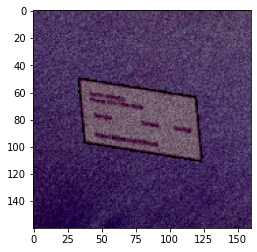

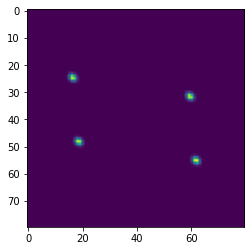

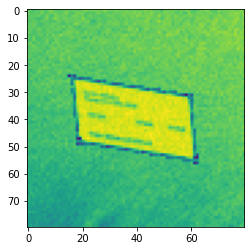

In [13]:
i=random.randint(0,len(augX)-1)
print(i)
#print(np.max(augY[i,:,:,0]))

plt.imshow(augX[i,:,:,:])
plt.show()

plt.imshow(augY[i,:,:,0])
plt.show()


xy_test =np.where(augY[i,:,:,0]>0.2,augY[i,:,:,0],cv2.resize(augX[i,:,:,0]+0.5,(80,80)))
plt.imshow(xy_test)
plt.show()

---
### data generator

In [14]:
class DataGenerator:
    def __init__(self, bg_files_list, detect_files_list, 
                 batch_size=6,
                 datan=6,
                 input_s=160,out_s=80,coner_s=8):
        self.bg_files_list = bg_files_list
        self.detect_files_list = detect_files_list
        
        self.batch_size = batch_size
        self.n = datan
        self.indexes = list(range(self.n))
        self.cur_index = 0
        
        self.input_s = input_s
        self.out_s = out_s
        self.coner_s = coner_s
        self.augX = None
        self.augY = None
        
        
        
        self.iter_n = 2000 #생성 데이터 반복수
        self.iter_idx = 2000
        self.build_data()
        
        
    def build_data(self):
        if self.iter_idx==self.iter_n:
        
            self.augX, self.augY= get_corner_dataset(self.bg_files_list, 
                                          self.detect_files_list, 
                                          datan=self.n,
                                          input_s=self.input_s,
                                          out_s=self.out_s,
                                          coner_s=self.coner_s)
        
            self.iter_idx==0
        else:
            pass
            #self.iter_idx+=1
        
    def next_sample(self):      ## index max -> 0 으로 만들기
        self.cur_index += 1
        if self.cur_index >= len(self.indexes) - 1 :
            self.cur_index = 0
            self.build_data()

            random.shuffle(self.indexes)
        return self.augX[self.indexes[self.cur_index]], self.augY[self.indexes[self.cur_index]]

    def next_batch(self):       ## batch size만큼 가져오기
        while True:
            X_data = np.zeros([self.batch_size, self.input_s, self.input_s, 3],dtype='float64')   
            Y_data = np.zeros([self.batch_size, self.out_s,self.out_s,1],dtype='float64')
            for i in range(self.batch_size):
                augX,augY =  self.next_sample()
                X_data[i,:,:,:]=augX
                Y_data[i,:,:,:]=augY
                
            yield X_data,Y_data
            

In [15]:
train_bn =32
train_gen=DataGenerator(bg_files_list, detect_files_list, 
                 batch_size=train_bn,
                 datan=1024,
                 input_s=160,out_s=80,coner_s=8)

In [16]:
val_bn=16
val_gen=DataGenerator(bg_files_list, detect_files_list, 
                 batch_size=val_bn,
                 datan=128,
                 input_s=160,out_s=80,coner_s=8)

In [17]:
a=next(iter(train_gen.next_batch()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


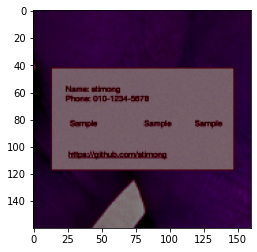

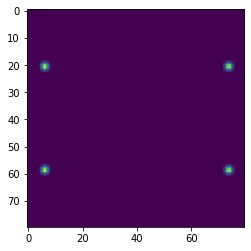

In [18]:
plt.imshow(a[0][0])
plt.show()

plt.imshow(a[1][0])
plt.show()

---
## train

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# model=get_corner_model()
# model.load_weights("models03/edge_detection.h5")

In [21]:
from datetime import date

today = date.today()
d1 = today.strftime("%Y%m%d")
print("d1 =", d1)

d1 = 20210224


In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

check_model_name = 'models03/edge_{}_160_v2.h5'.format(d1)
checkpoint = ModelCheckpoint(check_model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')#,period=1)
print(check_model_name)

es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=2, patience=100)

models03/edge_20210224_160_v2.h5


In [23]:
# from keras_radam import RAdam
from tensorflow.keras.optimizers import Adadelta,Adam,Nadam,Adamax,SGD
# model = build_keras_model(weights_path=None, backbone_name='vgg')
# opt = Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
opt = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
# opt =  tf.keras.optimizers.Adam(lr=0.0001)
# opt = RAdam(total_steps=10000, warmup_proportion=0.01, min_lr=1e-7)
# opt=SGD( lr = 0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5 )
model.compile(optimizer=opt, loss='mse')

In [119]:
train_gen.batch_size=32
val_gen.batch_size=16
history = model.fit_generator(generator=train_gen.next_batch(),#gen_train.generate(),
                                    steps_per_epoch=max(1, train_gen.n // train_gen.batch_size),# gt_util_train.num_objects // batch_size,
                                    epochs=200,
                                    validation_data=val_gen.next_batch(),#gen_val.generate(), # batch_size here?
                                    validation_steps=max(1, val_gen.n // val_gen.batch_size),#gt_util_val.num_objects // batch_size,
                                                  callbacks=[checkpoint,es ],
                                       use_multiprocessing=False,
                                                  max_queue_size=1,
                                       initial_epoch=0,
                                                 verbose=1)

Epoch 1/2
32/32 [==============================] - ETA: 0s - loss: 7.3221e-05
Epoch 00001: val_loss improved from 0.00008 to 0.00008, saving model to models03/edge_20210224_160_v2.h5
32/32 [==============================] - 88s 3s/step - loss: 7.3221e-05 - val_loss: 7.8498e-05
Epoch 2/2
32/32 [==============================] - ETA: 0s - loss: 6.8008e-05
Epoch 00002: val_loss improved from 0.00008 to 0.00007, saving model to models03/edge_20210224_160_v2.h5
32/32 [==============================] - 83s 3s/step - loss: 6.8008e-05 - val_loss: 6.8690e-05


In [44]:
# %time
# bsize=64
# epochs_n=7
# for i in range(2000):
#     print("-----------------------------------\ni: %d" %i)

#     if i>=0:
#         augX,augY= get_corner_dataset(bg_files_list, score_files_list, datan=300,
#                                       input_s=160,out_s=80, coner_s=8)
#         X= augX
#         Y= augY
        
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, shuffle=True)

#     if i==2:#
#         epochs_n= 10
#         opt = RAdam(total_steps=10000, warmup_proportion=0.01, min_lr=1e-7)
#         model.compile(optimizer=opt, loss='mse')

#     hist = model.fit(X_train,y_train, 
#               epochs=epochs_n,
#               batch_size=bsize,
#               validation_data=(X_test,y_test),
#              callbacks=[checkpoint])

---
## predict

### image

In [26]:
import matplotlib.pyplot as plt

In [116]:
def get_corner_img(frame, s=160):
    text_threshold=0.4


    re_timg = cv2.resize(frame,(s,s),interpolation = cv2.INTER_AREA) #cv2. #INTER_AREA
    input_x = np.expand_dims(re_timg, 0)
    input_x = (input_x/255) -0.5


    y_preds= model.predict(input_x) #(1, 320, 320, 2)
    y_pred_cur = y_preds[0]

    # Prepare data
    predict_map = y_pred_cur[..., 0].copy()
    
    img_h, img_w = predict_map.shape

    _, predict_score = cv2.threshold(predict_map,
                                  thresh=text_threshold,
                                  maxval=1,
                                  type=cv2.THRESH_BINARY)

    re_timg2= re_timg.copy()
    predict_score2 = cv2.resize(predict_score,(s, s))
    
    predict_score2 = cv2.cvtColor(predict_score2,cv2.COLOR_GRAY2BGR)
    re_timg2 = np.where(predict_score2>0.5,(255,0,0), re_timg2)
    
    return re_timg2.astype(frame.dtype)


In [25]:
# model=get_corner_model()
model.load_weights("models03/edge_20210224_160_v2.h5")

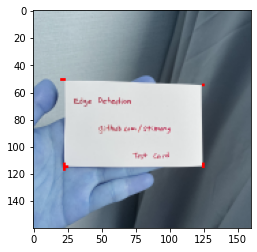

In [117]:
img_path ="samples/card_003.jpg"
img=cv2.imread(img_path)
plt.imshow(get_corner_img(img))
plt.show()

---
### video

In [118]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped



def web_trans_img(frame_, pts=[], s=160, text_threshold=0.4,pt_size=8):
    frame = frame_.copy()

    text_threshold=0.4
    fh, fw = frame.shape[:2]
    out_s = s//2 #80
    ori_r = fw/out_s

    re_timg = cv2.resize(frame,(s,s),interpolation = cv2.INTER_AREA) #cv2. #INTER_AREA
    input_x = np.expand_dims(re_timg, 0)
    input_x = (input_x/255) -0.5

    #predict
    y_preds= model.predict(input_x) #(1, 320, 320, 2)
    y_pred_cur = y_preds[0]

    # get corner
    textmap = y_pred_cur[..., 0].copy()
    
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    #iterations_size= iter_size
    textmap = cv2.dilate(textmap, rect_kernel, iterations = 1)  
    
    
    ret,thresh = cv2.threshold(textmap,text_threshold,255,0)
    thresh= thresh.astype("uint8")
    
    #print("thresh")
    #plt.imshow(thresh)
    #plt.show()

    contours = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    #print(len(contours))
    #pts = []
    if len(contours)!=4:
        #print("e")
        for pt in pts:
            ori_cX, ori_cY = pt
            cv2.circle(frame, (ori_cX, ori_cY), pt_size, (255, 0, 255), -1)
        return frame, pts,  False


    
    try:
        # loop over the contours
        pts=[]
        for c in contours:
            # compute the center of the contour
            M = cv2.moments(c, True)
            #print(M["m10"],M["m00"],M["m01"])
            cX = (M["m10"] / M["m00"])
            cY = (M["m01"] / M["m00"])

            ori_cX, ori_cY = int(cX*ori_r),int(cY*ori_r)
            pts.append([ori_cX, ori_cY])

            cv2.circle(frame, (ori_cX, ori_cY), pt_size, (255, 0, 255), -1)
        
        return frame, pts, True
    
    except Exception as e:
        #print("e:",e)
        #print("m",M["m10"], M["m00"])
        #print(ori_cX, ori_cY)
        return frame, pts, False



In [107]:
## video edge detection
capture = cv2.VideoCapture('samples/card_v03.MP4')


# 파일 쓰기
width  = capture.get(cv2.CAP_PROP_FRAME_WIDTH)   # float
height = capture.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float
print("width:",width)
print("height:",height)
fps = capture.get(cv2.CAP_PROP_FPS)
print("fps:",fps)
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
out = cv2.VideoWriter('samples/card_v03_edge.avi', fourcc, fps, (int(width),int(height)))

while (capture.isOpened()):
    ret, frame = capture.read()
    if ret:
        frame2, pts,  detect_on = web_trans_img(frame)
        out.write(frame2)
    else:
        break
        
capture.release()
out.release()
# capture.release()
# cv2.destroyAllWindows()

width: 750.0
height: 750.0
fps: 29.899590925994794
